In [1]:
import os
import numpy as np
from astropy.io import fits
from tqdm import tqdm
from PIL import Image
import cv2
import pickle
import matplotlib.pyplot as plt
from astropy.visualization import make_lupton_rgb
path = "/data/renhaoye/decals_2022/in_decals/fits/"
fits_files = os.listdir(path)
test_path = path + fits_files[251242]

In [ ]:
def load_img(filename):
    if ".fits" in filename:
        with fits.open(filename) as hdul:
            return hdul[0].data
    elif ".dat" in filename:
        with open(filename, "rb") as f:
            return pickle.load(f)
    else:
        raise TypeError
def normalization(img):
    """
    0-1 normalization
    img: img of 3 channels
    :return
    """
    global g_signal, r_signal, z_signal
    data_max = np.array([np.max(img[0]), np.max(img[1]), np.max(img[2])])
    data_min = np.array([np.min(img[0]), np.min(img[1]), np.min(img[2])])

    def compute(data, max, min):
        if max == min:
            return 0, True
        else:
            return (data - min) / (max - min), False
    for j in range(256):
        img[0][j], g_signal = compute(img[0][j], data_max[0], data_min[0])
        img[1][j], r_signal = compute(img[1][j], data_max[1], data_min[1])
        img[2][j], z_signal = compute(img[2][j], data_max[2], data_min[2])
    if g_signal or r_signal or z_signal:
        return img, True
    elif g_signal == r_signal == z_signal == False:
        return img, False
def cut(img):
    temp = img.reshape(-1)
    for i in range(temp.shape[0]):
        if temp[i] < 0:
            temp[i] = 0
        elif temp[i] > 255:
            temp[i] = 255
    return temp.reshape(3, 256, 256)
def color_balance(img):
    b, g, r = img[0], img[1], img[2]
    B, G, R = np.mean(b), np.mean(g), np.mean(r)
    K = (R + G + B) / 3
    Kb, Kg, Kr = K / B, K / G, K / R
    cv2.addWeighted(b, Kb, 0, 0, 0, b)
    cv2.addWeighted(g, Kg, 0, 0, 0, g)
    cv2.addWeighted(r, Kr, 0, 0, 0, r)
    return cv2.merge([b,g,r])

def ComputeMinLevel(hist, pnum):
    index = np.add.accumulate(hist)
    return np.argwhere(index>pnum * 8.3 * 0.01)[0][0]
def ComputeMaxLevel(hist, pnum):
    hist_0 = hist[::-1]
    Iter_sum = np.add.accumulate(hist_0)
    index = np.argwhere(Iter_sum > (pnum * 2.2 * 0.01))[0][0]
    return 255-index
def LinearMap(minlevel, maxlevel):
    if (minlevel >= maxlevel):
        return []
    else:
        index = np.array(list(range(256)))
        screenNum = np.where(index<minlevel,0,index)
        screenNum = np.where(screenNum> maxlevel,255,screenNum)
        for i in range(len(screenNum)):
            if screenNum[i]> 0 and screenNum[i] < 255:
                screenNum[i] = (i - minlevel) / (maxlevel - minlevel) * 255
        return screenNum
def CreateNewImg(img):
    h, w, d = img.shape
    newimg = np.zeros([h, w, d])
    for i in range(d):
        imghist = np.bincount(img[:, :, i].reshape(1, -1)[0])
        minlevel = ComputeMinLevel(imghist,  h * w)
        maxlevel = ComputeMaxLevel(imghist, h * w)
        screenNum = LinearMap(minlevel, maxlevel)
        if (screenNum.size == 0):
            continue
        for j in range(h):
            newimg[j, :, i] = screenNum[img[j, :, i]]
    return newimg
img = load_img(test_path)
# img = cut(img)
print(test_path)

In [ ]:
g = img[0]

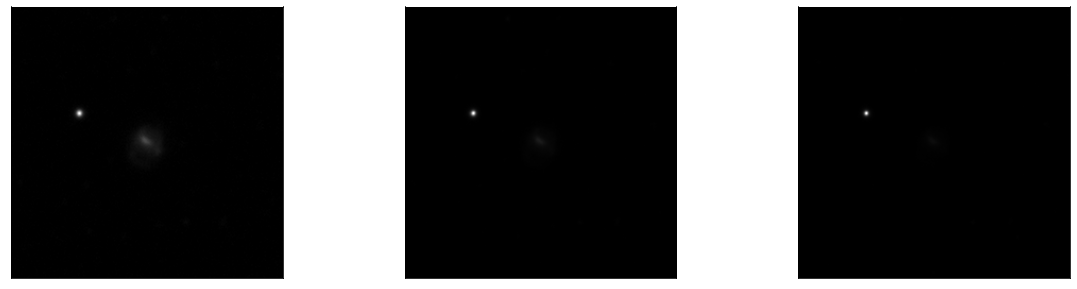

In [3]:
plt.figure(figsize=(20,5))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.imshow(img[i], cmap="gray")
    plt.xticks([])
    plt.yticks([])
plt.show()

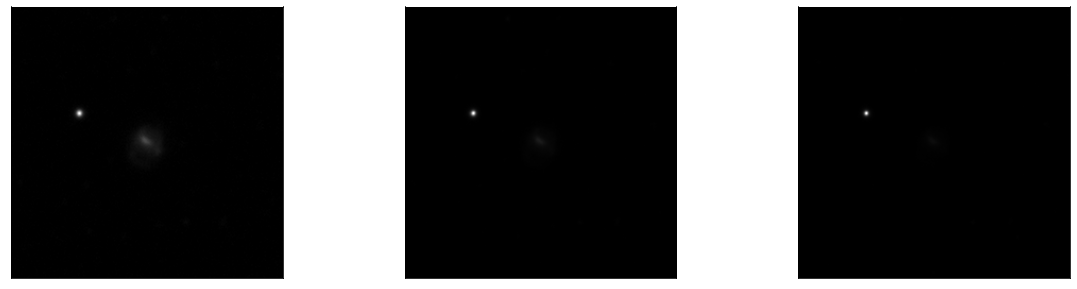

In [4]:
normalized_img, _ = normalization(img)
normalized_img_255 = normalized_img * 255
plt.figure(figsize=(20,5))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.imshow(normalized_img_255[i], cmap="gray")
    plt.xticks([])
    plt.yticks([])
plt.show()

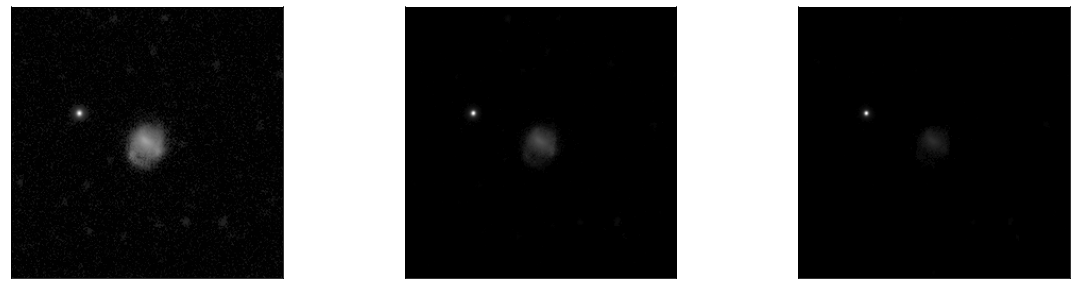

In [5]:
normalized_img_uint8 = normalized_img_255.astype(np.uint8)
clahe = cv2.createCLAHE(clipLimit=10, tileGridSize=(8,8))
cl_g = clahe.apply(normalized_img_uint8[0])
cl_r = clahe.apply(normalized_img_uint8[1])
cl_z = clahe.apply(normalized_img_uint8[2])
plt.figure(figsize=(20,5))
plt.subplot(131)
plt.imshow(cl_g, cmap="gray")
plt.xticks([])
plt.yticks([])
plt.subplot(132)
plt.imshow(cl_r, cmap="gray")
plt.xticks([])
plt.yticks([])
plt.subplot(133)
plt.imshow(cl_z, cmap="gray")
plt.xticks([])
plt.yticks([])
plt.show()

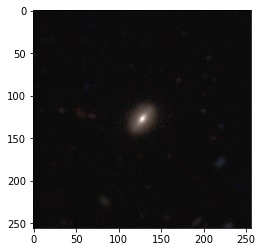

In [10]:
cl_rgb = np.array((cl_g, cl_r, cl_z))
cl_rgb = cl_rgb.swapaxes(0, 1)
cl_rgb = cl_rgb.swapaxes(1, 2)
plt.imshow(cl_rgb)
plt.show()